# Modelruns for Delay Prediction on Departure Flights  
in this Notebook different Models will be tested and adjusted to find the best match for the delay prediction on flight events.

In [1]:
# Importing Packages
import pandas as pd
from datetime import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

from tensorflow.keras.layers import Input   # for defining the shape of the input layer
from tensorflow.keras.models import Sequential   # to create sequence of layers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization  # different types of layers
from tensorflow.keras.regularizers import l2    # applying regularization to help prevent overfitting (penalize larger Weights)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau    # callbacks to control and improve training


In [2]:
# Removed ö,ä,ü, and special characters from dataset before import
# Import Data from adjusted csv 
movements = pd.read_csv("Flugbewegungen_export_20231029-20240918.csv", sep = ";")

# transform Day column to datetime 
movements['Tag'] = pd.to_datetime(movements['Tag'], format='%d.%m.%Y')

# Add Columns Season, weekday, month, hour, minute, from both STA/STD and ATA/ATD, delayminutes
startW23 = datetime(2023, 10, 29)
startS24 = datetime(2024, 3, 31)
startW24 = datetime(2024, 10, 27)

movements['season'] = np.where((movements['Tag'].dt.date >= startW23.date()) &
                               (movements['Tag'].dt.date < startS24.date()), 'W23', 'S24')

movements['STA_STD_Datetime'] = pd.to_datetime(movements['Tag'].astype(str) + " " + movements['STA_STD_Time'].astype(str).str[-8:])
movements['ATA_ATD_Datetime'] = pd.to_datetime(movements['Tag'].astype(str) + " " + movements['ATA_ATD_Time'].astype(str).str[-8:])
movements['weekdaySTA_STD'] = movements['STA_STD_Datetime'].dt.dayofweek
movements['daySTA_STD'] = movements['STA_STD_Datetime'].dt.day
movements['monthSTA_STD'] = movements['STA_STD_Datetime'].dt.month
movements['yearSTA_STD'] = movements['STA_STD_Datetime'].dt.year
movements['hourSTA_STD'] = movements['STA_STD_Datetime'].dt.hour
movements['minuteSTA_STD'] = movements['STA_STD_Datetime'].dt.minute
movements['weekdayATA_ATD'] = movements['ATA_ATD_Datetime'].dt.dayofweek
movements['dayATA_ATD'] = movements['ATA_ATD_Datetime'].dt.day
movements['monthATA_ATD'] = movements['ATA_ATD_Datetime'].dt.month
movements['yearATA_ATD'] = movements['ATA_ATD_Datetime'].dt.year
movements['hourATA_ATD'] = movements['ATA_ATD_Datetime'].dt.hour
movements['minuteATA_ATD'] = movements['ATA_ATD_Datetime'].dt.minute
movements['DelayMinutes'] = (movements['ATA_ATD_Datetime']-movements['STA_STD_Datetime']).dt.total_seconds()/60


###Remove error values###
# 'GA Flag' : replace Y with True and  - with False
# 'Schengen' : replace 'Schengen' with True and 'Non-Schengen' with false

movements_cleaned = movements.copy()
movements_cleaned['GA Flag'] = movements_cleaned['GA Flag'].replace({'Y': True, '-': False})
movements_cleaned['Schengen'] = movements_cleaned['Schengen'].replace({'Schengen': True, 'Non-Schengen': False})
movements_cleaned['Bewegungsart LSV'] = movements_cleaned['Bewegungsart LSV'].replace( {'L': 'Arrival', 'S': 'Departure'})
movements_cleaned = movements_cleaned[movements_cleaned['GA Flag'] == False]

# Replace '-' in '2 let code airline' with first 2 letters from 'Flugnummer'
movements_cleaned['2 let code airline'] = movements_cleaned.apply(lambda row: row['Flugnummer'][:2] if row['2 let code airline'] == '-' else row['2 let code airline'], axis=1)




C:\Users\louis\AppData\Local\Temp\ipykernel_4224\2250073164.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  movements_cleaned['GA Flag'] = movements_cleaned['GA Flag'].replace({'Y': True, '-': False})
C:\Users\louis\AppData\Local\Temp\ipykernel_4224\2250073164.py:39: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  movements_cleaned['Schengen'] = movements_cleaned['Schengen'].replace({'Schengen': True, 'Non-Schengen': False})


In [3]:
# Get 4 Letter Code Airport 
airport_codes = pd.read_csv(r"C:/Users/louis/Documents/CAS_Louisa/DataImport/ICAO_IATA_Airport.txt", sep=",")
airport_codes.head(3)


,IATA,ICAO,NAME
0,AAA,NTGA,Anaa Airport
1,AAB,YARY,Arrabury Airport
2,AAC,HEAR,El Arish International Airport


In [4]:
# Rename '3 let code Airport' in movements_Cleaned to 'IATA' for merging
movements_cleaned = movements_cleaned.rename(columns={'3 let code Airport': 'IATA'})

# Merge movements_cleaned with airport_codes on the 'IATA' column
# We use how='left' to keep all rows from movements_cleaned and add the ICAO column from airport_codes
movements_cleaned = movements_cleaned.merge(airport_codes[['IATA', 'ICAO']], on='IATA', how='left')
movements_cleaned = movements_cleaned.rename(columns={'IATA':'3 let code Airport',
                                                      'ICAO':'ICAO_Airport'})

# Step 3: Verify that the ICAO column has been added
movements_cleaned.head()


,Bewegungsart LSV,Tag,STA_STD_Time,ATA_ATD_Time,2 let code airline,Flugnummer,Registration,city name,3 let code Airport,AC Type 4 Letter,...,hourSTA_STD,minuteSTA_STD,weekdayATA_ATD,dayATA_ATD,monthATA_ATD,yearATA_ATD,hourATA_ATD,minuteATA_ATD,DelayMinutes,ICAO_Airport
0,Arrival,2023-10-29,05:10:00,05:14:32,LX,LX177,HBJNF,Singapore,SIN,B77W,...,5,10,6,29,10,2023,5,14,4.533333,WSSS
1,Arrival,2023-10-29,05:10:00,05:20:38,LX,LX243,HBJHD,Dubai,DXB,A333,...,5,10,6,29,10,2023,5,20,10.633333,OMDB
2,Arrival,2023-10-29,05:10:00,05:36:45,LX,LX139,HBJMH,Hong Kong,HKG,A343,...,5,10,6,29,10,2023,5,36,26.750000,VHHH
3,Arrival,2023-10-29,05:15:00,05:09:52,LX,LX055,HBJHA,Boston,BOS,A333,...,5,15,6,29,10,2023,5,9,-5.133333,KBOS
4,Arrival,2023-10-29,05:15:00,05:19:29,LX,LX017,HBJHG,New York,JFK,A333,...,5,15,6,29,10,2023,5,19,4.483333,KJFK


## ICAO Airport  
The ICAO Airport can be used to separate the directions where flights are going or coming from. 
The first Letter is the biggest Region such as L for the southern part of Europe and E for the northern part of Europe such as the UK and Sweden, Norway, Germany, Denmark etc. 
The second letter stands for the Country. The remaining 2 letters correspond to the airport in the country. 


In [5]:
# Create three new columns for the first letter, second letter, and remaining two letters of ICAO
movements_cleaned['ICAO_First'] = movements_cleaned['ICAO_Airport'].str[0]    # First letter for Region
movements_cleaned['ICAO_Second'] = movements_cleaned['ICAO_Airport'].str[1]   # Second letter for Country
movements_cleaned['ICAO_Remaining'] = movements_cleaned['ICAO_Airport'].str[2:]  # Remaining two letters

# Verify the new columns
movements_cleaned[['ICAO_Airport', 'ICAO_First', 'ICAO_Second', 'ICAO_Remaining']].head()

,ICAO_Airport,ICAO_First,ICAO_Second,ICAO_Remaining
0,WSSS,W,S,SS
1,OMDB,O,M,DB
2,VHHH,V,H,HH
3,KBOS,K,B,OS
4,KJFK,K,J,FK


In [6]:
# Create Dictionary on the Size Codes of available Aircraft 4 Letters
size_code_dict = {
    'B77W': 'E', 'A333': 'E', 'A343': 'E', 'B789': 'E', 'B763': 'D', 
    'A359': 'E', 'B738': 'C', 'B788': 'E', 'E190': 'C', 'BCS1': 'C', 
    'A319': 'C', 'A20N': 'C', 'E195': 'C', 'DH8D': 'B', 'B77L': 'E', 
    'B764': 'D', 'B38M': 'C', 'A388': 'F', 'CRJ9': 'B', 'A332': 'E', 
    'B733': 'C', 'B737': 'C', 'B739': 'C', 'PC12': 'A', 'E75L': 'C', 
    'E75S': 'C', 'B39M': 'C', 'B752': 'D', 'B78X': 'E', 'E135': 'B', 
    'B744': 'F', 'E170': 'C', 'B735': 'C', 'A318': 'C', 'SF34': 'A', 
    'A124': 'F', 'A310': 'D', 'A35K': 'E', 'CRJX': 'B', 'B772': 'E', 
    'A339': 'E', 'AT75': 'B', 'B753': 'D', 'E145': 'B', 'B734': 'C', 
    'CRJ2': 'B', 'SB20': 'A', 'AN26': 'B'
}

In [7]:
# Map the AC Type Codes to the Size Code of the Dictionary and save in separate Column
movements_cleaned['size_code'] = movements_cleaned['AC Type 4 Letter'].map(size_code_dict)

In [8]:
# Group the 'DelayMinutes' by 'Bewegungsart LSV' and create two dataframes one for arrivals and one for departures
# Filter the DataFrame for rows where 'Bewegungsart LSV' is 'Arrival'
arr = movements_cleaned[movements_cleaned['Bewegungsart LSV'] == 'Arrival']

# Filter the DataFrame for rows where 'Bewegungsart LSV' is 'Departure'
dep = movements_cleaned[movements_cleaned['Bewegungsart LSV'] == 'Departure']
     

# Create Features for Model  
Several variations of Features were tested.  
For the Random Forest and the XGBoost Regressor there seemed to be the best results with only "Schengen", "season", "size_code", "ICAP_First" and "ICAO_Second" for the One Hot Encoding. 
The Time and Date variables were encoded to cyclical features.

In [9]:
# Create Features for Airline / AC Type / Schengen / Season
one_hot_arrivals = pd.get_dummies(arr, columns=['2 let code airline', '3 let code Airport','Schengen', 'season','size_code', 'ICAO_First', 'ICAO_Second'])
one_hot_departures = pd.get_dummies(dep, columns=['2 let code airline', '3 let code Airport','Schengen', 'season','size_code', 'ICAO_First', 'ICAO_Second'])

# Drop rest of Columns 
one_hot_arrivals_clean = one_hot_arrivals.drop([ 'Bewegungsart LSV','Flugnummer', 'Registration', 'city name', 'AC Type 3 Letter','AC Type 4 Letter', 'Airline Name', 'RTK', 'Gate',  'ATM definitiv', 'ATM prov.','STA_STD_Time','ATA_ATD_Time','weekdayATA_ATD', 'monthATA_ATD', 'hourATA_ATD', 'minuteATA_ATD','dayATA_ATD', 'yearATA_ATD','GA Flag','ICAO_Airport', 'ICAO_Remaining'], axis=1)
one_hot_departures_clean = one_hot_departures.drop([ 'Bewegungsart LSV','Flugnummer', 'Registration', 'city name', 'AC Type 3 Letter','AC Type 4 Letter', 'Airline Name', 'RTK', 'Gate',  'ATM definitiv', 'ATM prov.','STA_STD_Time','ATA_ATD_Time','weekdayATA_ATD', 'monthATA_ATD', 'hourATA_ATD', 'minuteATA_ATD','dayATA_ATD', 'yearATA_ATD','GA Flag','ICAO_Airport','ICAO_Remaining'], axis=1)



In [10]:
# Add Cyclical Features
# transform 'Tag' into the number of the day of the year
one_hot_arrivals_clean['Tag'] = pd.to_datetime(one_hot_arrivals_clean['Tag']).dt.dayofyear
one_hot_departures_clean['Tag'] = pd.to_datetime(one_hot_departures_clean['Tag']).dt.dayofyear


# Function to check for leap year
def is_leap_year(year):
    return (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)

# Create sine and cosine features for days, months, hours, and minutes
def add_cyclical_features(df):
    for index, row in df.iterrows():
        month = row['monthSTA_STD']
        day = row['daySTA_STD']
        year = row['yearSTA_STD']
        hour = row['hourSTA_STD']
        minute = row['minuteSTA_STD']
        weekday = row['weekdaySTA_STD']

        # Determine the number of days in the month
        if month in [1, 3, 5, 7, 8, 10, 12]:  # 31 days
            N_days = 31
        elif month in [4, 6, 9, 11]:  # 30 days
            N_days = 30
        elif month == 2:  # February
            N_days = 29 if is_leap_year(year) else 28

        # Apply transformations for day
        df.at[index, 'sin_day'] = np.sin(2 * np.pi * day / N_days)
        df.at[index, 'cos_day'] = np.cos(2 * np.pi * day / N_days)

        # Apply transformations for month
        N_months = 12
        df.at[index, 'sin_month'] = np.sin(2 * np.pi * month / N_months)
        df.at[index, 'cos_month'] = np.cos(2 * np.pi * month / N_months)

        # Apply transformations for hour
        N_hours = 24
        df.at[index, 'sin_hour'] = np.sin(2 * np.pi * hour / N_hours)
        df.at[index, 'cos_hour'] = np.cos(2 * np.pi * hour / N_hours)

        # Apply transformations for minute
        N_minutes = 60
        df.at[index, 'sin_minute'] = np.sin(2 * np.pi * minute / N_minutes)
        df.at[index, 'cos_minute'] = np.cos(2 * np.pi * minute / N_minutes)

        # Apply transformations for weekday
        N_weekday = 7
        df.at[index, 'sin_minute'] = np.sin(2 * np.pi * weekday / N_weekday)
        df.at[index, 'cos_minute'] = np.cos(2 * np.pi * weekday / N_weekday)


# Add cyclical features to both DataFrames
add_cyclical_features(one_hot_arrivals_clean)
add_cyclical_features(one_hot_departures_clean)


# remove the original columns
one_hot_arrivals_clean_format = one_hot_arrivals_clean.drop(['Tag','weekdaySTA_STD', 'ATA_ATD_Datetime', 'monthSTA_STD', 'hourSTA_STD', 'minuteSTA_STD', 'daySTA_STD', 'yearSTA_STD'], axis=1)
one_hot_departures_clean_format = one_hot_departures_clean.drop(['Tag','weekdaySTA_STD', 'ATA_ATD_Datetime', 'monthSTA_STD', 'hourSTA_STD', 'minuteSTA_STD', 'daySTA_STD', 'yearSTA_STD'], axis=1)


# Get Features for Model
features_arr = one_hot_arrivals_clean_format.columns.tolist()
features_arr.remove('STA_STD_Datetime')
features_arr.remove('DelayMinutes')
features_dep = one_hot_departures_clean_format.columns.tolist()
features_dep.remove('STA_STD_Datetime')
features_dep.remove('DelayMinutes')

### Decision on Outlier-Cutting  
Several Variations of Outlier-Cuttings were tested in the models and the best result seemed to be the one in the box below.

In [11]:
# remove outliers from Dataset 
# Calculate the 5th and 95th percentiles of arrival dataset
lower_bound_arr = np.percentile(one_hot_arrivals_clean_format['DelayMinutes'], 0.5)
upper_bound_arr = np.percentile(one_hot_arrivals_clean_format['DelayMinutes'], 95)

# Calculate the 5th and 95th percentiles of departure dataset
lower_bound_dep = np.percentile(one_hot_departures_clean_format['DelayMinutes'], 0.5)
upper_bound_dep = np.percentile(one_hot_departures_clean_format['DelayMinutes'], 95)

# remove all rows where delay minutes < lower bound or > upper bound
one_hot_arrivals_clean_format_no_outliers = one_hot_arrivals_clean_format[(one_hot_arrivals_clean_format['DelayMinutes'] >= lower_bound_arr)]
one_hot_arrivals_clean_format_no_outliers = one_hot_arrivals_clean_format_no_outliers[(one_hot_arrivals_clean_format_no_outliers['DelayMinutes'] <= upper_bound_arr)]

one_hot_departures_clean_format_no_outliers = one_hot_departures_clean_format[(one_hot_departures_clean_format['DelayMinutes'] >= lower_bound_dep)]
one_hot_departures_clean_format_no_outliers = one_hot_departures_clean_format_no_outliers[(one_hot_departures_clean_format_no_outliers['DelayMinutes'] <= upper_bound_dep)]


## Random Forest Regressor Model 
#### Test for best Hyperparameters 

In [12]:
# # Prepare data (as you already have)
# X = one_hot_departures_clean_format_no_outliers[features_dep]
# y = one_hot_departures_clean_format_no_outliers['DelayMinutes']

# # First split: 60% training, 40% testing/validation
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# # Second split: 50% of the temp set for testing and 50% for validation
# X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# # Define the model
# rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': [1.0, 'sqrt']
# }

# # Initialize Grid Search
# grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,

#                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, verbose=2)

# # Fit Grid Search
# grid_search.fit(X_train, y_train)
 
# # Get the best parameters
# best_rf_model = grid_search.best_estimator_
# print("Best parameters found: ", grid_search.best_params_)

# # Make predictions using the best model
# rf_predictions_dep = best_rf_model.predict(X_test)

# # Evaluate models
# def evaluate_model(y_true, y_pred, model_name):
#     mae = mean_absolute_error(y_true, y_pred)
#     mse = mean_squared_error(y_true, y_pred)
#     r2 = r2_score(y_true, y_pred)

#     print(f"{model_name} Performance:")
#     print(f"  Mean Absolute Error: {mae:.2f}")
#     print(f"  Mean Squared Error: {mse:.2f}")
#     print(f"  R² Score: {r2:.2f}\n")

 
# # Evaluate on test set
# evaluate_model(y_test, rf_predictions_dep, "Random Forest Departures")

# # Optionally evaluate on validation set
# rf_predictions_val = best_rf_model.predict(X_val)
# evaluate_model(y_val, rf_predictions_val, "Random Forest Departures Validation")

 
# # Get the best parameters found during Grid Search
# best_params = grid_search.best_params_
# print("Best hyperparameters found:")
# for param, value in best_params.items():
#     print(f"{param}: {value}")
 

## Random Forest Regressor Model 
#### Model run with best Hyperparameters and show feature importance

In [13]:
# Define the feature matrix X and the target vector y
X = one_hot_departures_clean_format_no_outliers[features_dep]  # Features
y = one_hot_departures_clean_format_no_outliers['DelayMinutes']  # Target

# Split the data: 60% training, 20% testing, 20% validation
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Train the model on the training data
departure_model_RF = RandomForestRegressor(
    max_depth = None, 
    max_features = 'sqrt',
    min_samples_leaf = 4,
    min_samples_split = 10,
    n_estimators = 200,
    random_state = 42
    )
departure_model_RF.fit(X_train, y_train)



# Make predictions on test and validation sets
y_pred_test = departure_model_RF.predict(X_test)
y_pred_val = departure_model_RF.predict(X_val)

# Calculate metrics for the test set
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Calculate metrics for the validation set
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

# Print metrics
print("Test Set Metrics from best Random Forest Regressor Model:")
print(f"MSE (Test): {mse_test:.4f}")
print(f"MAE (Test): {mae_test:.4f}")
print(f"R² (Test): {r2_test:.4f}")

print("\nValidation Set Metrics from best Random Forest Regressor Model:")
print(f"MSE (Validation): {mse_val:.4f}")
print(f"MAE (Validation): {mae_val:.4f}")
print(f"R² (Validation): {r2_val:.4f}")

Test Set Metrics from best Random Forest Regressor Model:
MSE (Test): 172.7586
MAE (Test): 9.9817
R² (Test): 0.2166

Validation Set Metrics from best Random Forest Regressor Model:
MSE (Validation): 174.6944
MAE (Validation): 10.0433
R² (Validation): 0.2218


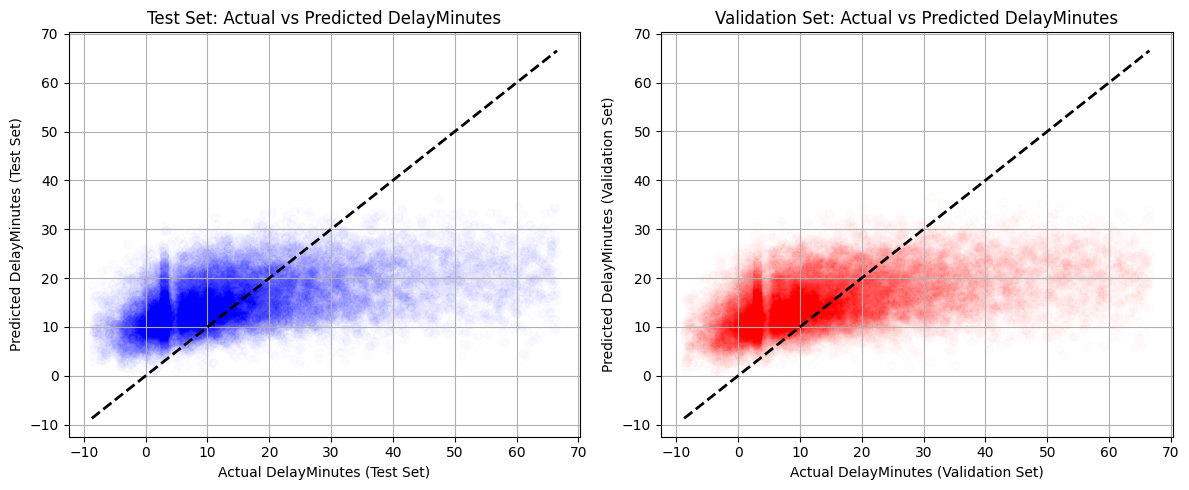

In [14]:
# Scatter plot for Test Set
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.01, color="b")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2)
plt.xlabel("Actual DelayMinutes (Test Set)")
plt.ylabel("Predicted DelayMinutes (Test Set)")
plt.title("Test Set: Actual vs Predicted DelayMinutes")
plt.grid(True)

# Scatter plot for Validation Set
plt.subplot(1, 2, 2)
plt.scatter(y_val, y_pred_val, alpha=0.01, color="r")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], "k--", lw=2)
plt.xlabel("Actual DelayMinutes (Validation Set)")
plt.ylabel("Predicted DelayMinutes (Validation Set)")
plt.title("Validation Set: Actual vs Predicted DelayMinutes")
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()

In [15]:
# Get feature importances
departure_importances_RF = departure_model_RF.feature_importances_
feature_names_dep = features_dep

# Sort feature importances in ascending order
departure_indices = departure_importances_RF.argsort()[::-1]

# Display feature importances sorted in descending order
sorted_feature_importances = [(feature_names_dep[i], departure_importances_RF[i]) for i in departure_indices if departure_importances_RF[i] > 0.005]

# print("\nFeature importances sorted in descending order:")
# for feature, importance in sorted_feature_importances:
#     print(f"{feature}: {importance:.4f}")

# Evaluating on validation data With R^2 Score:
val_score_RF = departure_model_RF.score(X_val, y_val)
print(f"Validation R^2 Score: {val_score_RF}")

Validation R^2 Score: 0.22181166122392526


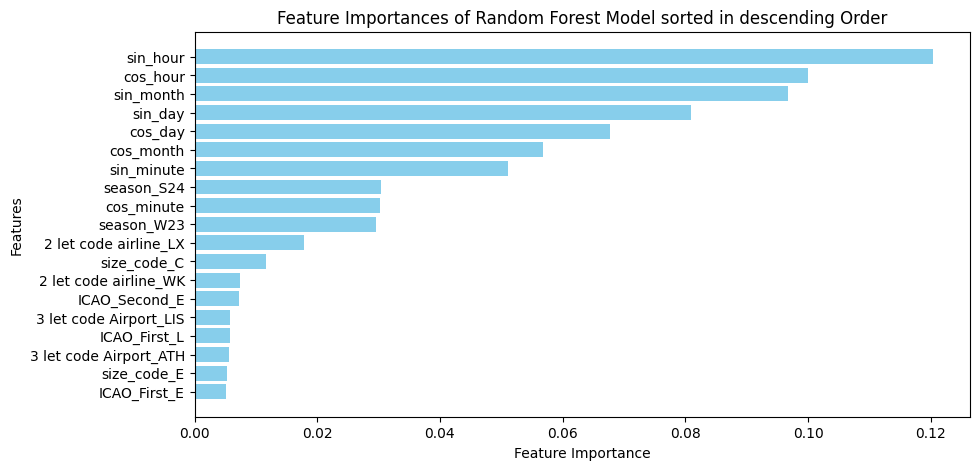

In [16]:
# Extract features and their importance values for plotting
features_RF = [feature for feature, importance in sorted_feature_importances]
importances_RF = [importance for feature, importance in sorted_feature_importances]

# Plot Feature Importances for Random Forest Regressor Model 
plt.figure(figsize=(10, 5))
plt.barh(features_RF, importances_RF, color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importances of Random Forest Model sorted in descending Order")
plt.gca().invert_yaxis()  # To have the highest importance at the top
plt.show()

### Summary of Random Forest Regressor Model   
The Random Forest Regressor Model provides the following result for the Validation Data:  
***Validation Set Metrics from best Random Forest Regressor Model:***   
*MSE (Validation): 174.69446*  
*MAE (Validation): 10.0433*   
*R² (Validation): 0.2218*   


The most important Features are the Date Time Variables, followed by Code Size, certain Airline Codes and the destination information:  
*- Hour*  
*- Month*  
*- Day*  
*- Minute*  
*- Season*  
*- Airline Information*  
*- Aircraft Size*  
*- ICAO Destination Information*  

---

## XGBoost Regression Model 
#### Test for best Hyperparameters

In [17]:
# # Define parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 6, 10],
#     'min_child_weight': [1, 5, 10],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
# }

# # Create a GridSearchCV object with MAE as the scoring metric
# grid_search = GridSearchCV(
#     estimator=xgb.XGBRegressor(random_state=42),
#     param_grid=param_grid,
#     scoring='neg_mean_absolute_error',  # Use MAE for scoring
#     cv=3,
#     n_jobs=-1,
#     verbose=2
# )

# # Fit the grid search to the training data
# grid_search.fit(X_train, y_train)

# # Get the best parameters
# best_params = grid_search.best_params_
# print("Best parameters found: ", best_params)

# # Use the best parameters to fit the model
# xgb_model_dep = xgb.XGBRegressor(**best_params, random_state=42)
# xgb_model_dep.fit(X_train, y_train, evals=[(X_val, y_val)], early_stopping_rounds=10, verbose=True)

# # Make predictions
# xgb_predictions_dep = xgb_model_dep.predict(X_test)

# # Evaluate the model
# evaluate_model(y_test, xgb_predictions_dep, "XGBoost Departures")

# import xgboost as xgb
# print(xgb.__version__)

 

## XGBoost Regression Model
#### Model run with best Hyperparameters and show feature importance

In [18]:
# Define the feature matrix X and the target vector y
X = one_hot_departures_clean_format_no_outliers[features_dep]  # Features
y = one_hot_departures_clean_format_no_outliers['DelayMinutes']  # Target

# Split the data: 60% training, 20% testing, 20% validation
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Train the model on the training data
departure_model_XGB = xgb.XGBRegressor(
    colsample_bytree = 0.6,             # Fraction of features to be sampled for each tree
    learning_rate = 0.05,               # how much each tree contributes to final prediction - slow learning /small number prevents overfitting
    max_depth = 20,                     # max depth of tree - higher more complexity but danger of overfitting
    min_child_weight = 10,              # min sum of instance weight in the leaf
    n_estimators = 200,                 # number of boosting rounds/trees to build
    subsample = 1.0,                    # fraction of the training data to be used for each tree
    random_state=42,                    # reproducibility
    n_jobs = -1)                        # use all available cores for training
departure_model_XGB.fit(X_train, y_train)



# Make predictions on test and validation sets
y_pred_test = departure_model_XGB.predict(X_test)
y_pred_val = departure_model_XGB.predict(X_val)

# Calculate metrics for the test set
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Calculate metrics for the validation set
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

# Print metrics
print("Test Set Metrics:")
print(f"MSE (Test): {mse_test:.4f}")
print(f"MAE (Test): {mae_test:.4f}")
print(f"R² (Test): {r2_test:.4f}")

print("\nValidation Set Metrics:")
print(f"MSE (Validation): {mse_val:.4f}")
print(f"MAE (Validation): {mae_val:.4f}")
print(f"R² (Validation): {r2_val:.4f}")

Test Set Metrics:
MSE (Test): 162.0651
MAE (Test): 9.5283
R² (Test): 0.2651

Validation Set Metrics:
MSE (Validation): 161.9287
MAE (Validation): 9.4893
R² (Validation): 0.2787


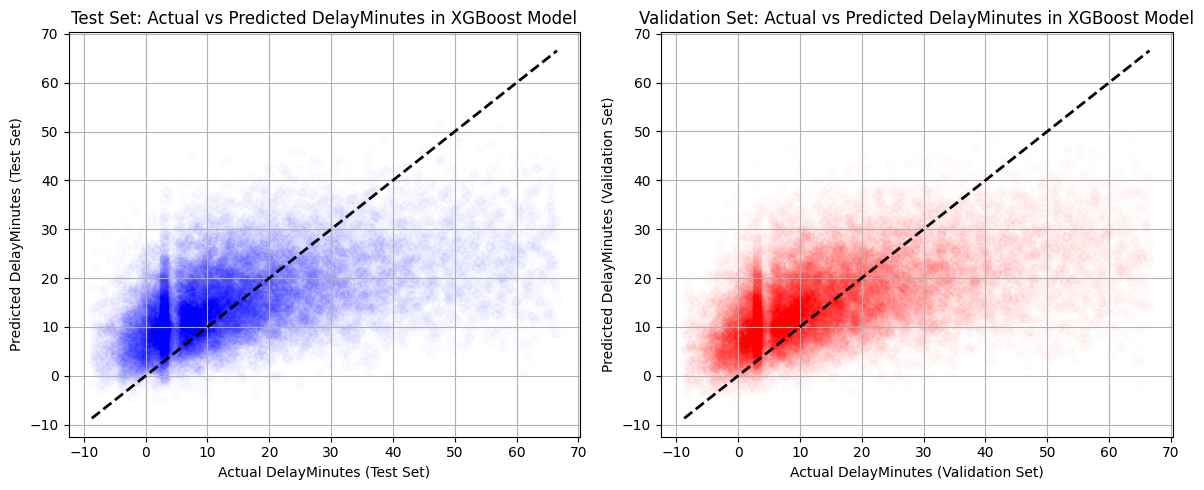

In [19]:
# Scatter plot for Test Set
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.01, color="b")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2)
plt.xlabel("Actual DelayMinutes (Test Set)")
plt.ylabel("Predicted DelayMinutes (Test Set)")
plt.title("Test Set: Actual vs Predicted DelayMinutes in XGBoost Model")
plt.grid(True)

# Scatter plot for Validation Set
plt.subplot(1, 2, 2)
plt.scatter(y_val, y_pred_val, alpha=0.01, color="r")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], "k--", lw=2)
plt.xlabel("Actual DelayMinutes (Validation Set)")
plt.ylabel("Predicted DelayMinutes (Validation Set)")
plt.title("Validation Set: Actual vs Predicted DelayMinutes in XGBoost Model")
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()

16.885340652465818


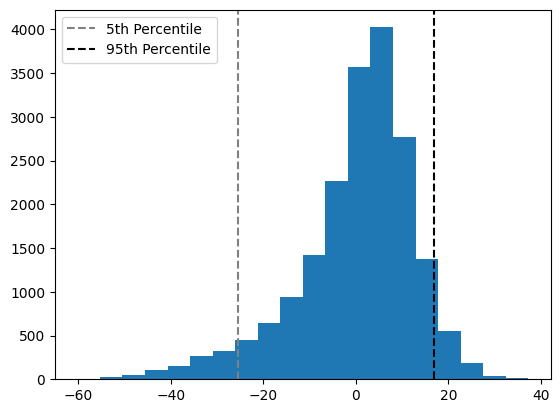

In [20]:
# Positive when too much delay predicted / negative when too little predicted 
error_XGB =y_pred_test-y_test
percentile_5 = np.percentile(error_XGB,5)
percentile_95 = np.percentile(error_XGB,95)
print(percentile_95)
plt.hist(error_XGB, bins = 20)
plt.axvline(percentile_5, color='grey', linestyle='dashed', label = "5th Percentile")
plt.axvline(percentile_95,color = 'black', linestyle='dashed', label = "95th Percentile")
plt.legend()
plt.show()

In [21]:
# Get feature importances
departure_importances = departure_model_XGB.feature_importances_
feature_names_dep = features_dep

# Sort feature importances in ascending order
departure_indices = departure_importances.argsort()[::-1]

# Display feature importances sorted in ascending order
sorted_feature_importances = [(feature_names_dep[i], departure_importances[i]) for i in departure_indices if departure_importances[i] > 0.005]

# print("\nFeature importances sorted in ascending order:")
# for feature, importance in sorted_feature_importances:
#     print(f"{feature}: {importance:.4f}")

# Evaluating on validation data With R^2 Score:
val_score_XGB = departure_model_XGB.score(X_val, y_val)
print(f"Validation R^2 Score: {val_score_XGB}")

Validation R^2 Score: 0.27867715723584374


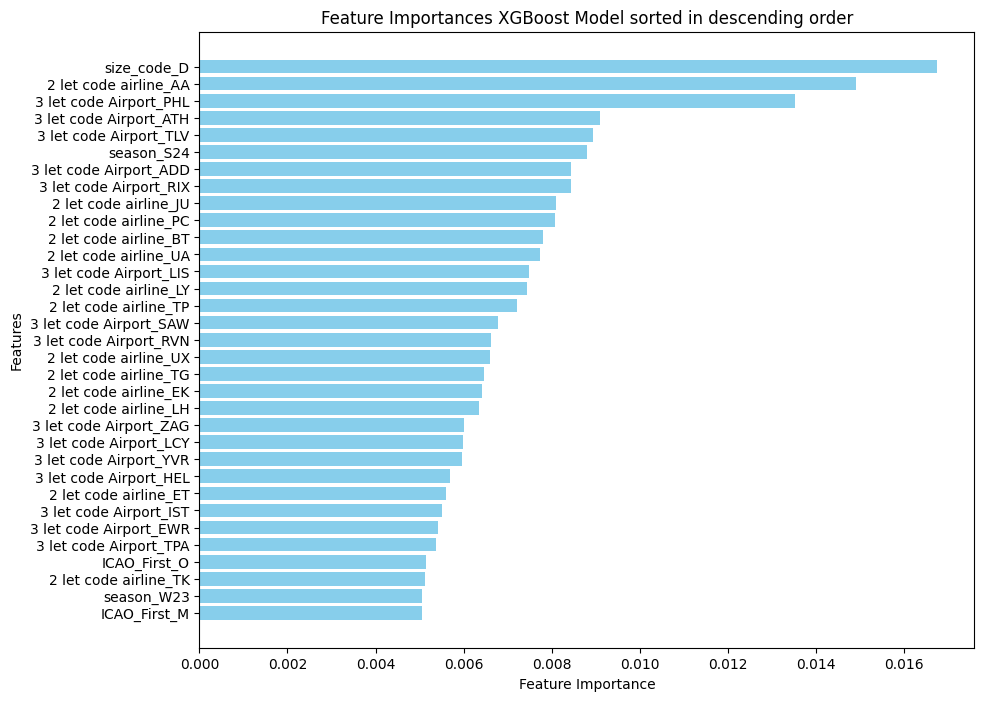

In [22]:
# Extract features and their importance values for plotting
features_XGB = [feature for feature, importance in sorted_feature_importances]
importances_XGB = [importance for feature, importance in sorted_feature_importances]

# Plot Feature Importances for XGBoost Regressor Model 
plt.figure(figsize=(10, 8))
plt.barh(features_XGB, importances_XGB, color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importances XGBoost Model sorted in descending order")
plt.gca().invert_yaxis()  # To have the highest importance at the top
plt.show()

### Summary of XGBoost Regressor Model   
The XGBoost Regressor Model provides the following result for the Validation Data:  
***Validation Set Metrics from best XGBoost Regressor Model:***   
*MSE (Validation): 161.9287*  
*MAE (Validation): 9.4893*   
*R² (Validation): 0.2787*   


The most important Features are the Date Time Variables, followed by Code Size, certain Airline Codes and the destination information:  
*- Aircraft Size*  
*- Airline Information*  
*- ICAO Destination Information*  
*- Season*  


## Test Neural Network

#### Test Initial Model 

In [23]:
# Define the feature matrix X and the target vector y
X = one_hot_departures_clean_format_no_outliers[features_dep]  # Features
y = one_hot_departures_clean_format_no_outliers['DelayMinutes']  # Target

# Split the data: 60% training, 20% testing, 20% validation
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize the data (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# Define the fully connected neural network
model_basic = Sequential()

# Input layer + 5 hidden layers with 100 neurons each and ReLU activation
model_basic.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))  # Input layer
model_basic.add(Dense(100, activation='relu'))  # Hidden layers
model_basic.add(Dense(100, activation='relu'))
model_basic.add(Dense(100, activation='relu'))
model_basic.add(Dense(100, activation='relu'))

# Output layer (for regression, no activation function)
model_basic.add(Dense(1, activation='linear'))

# Compile the model
model_basic.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_squared_error'])

# Train the model
history = model_basic.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Evaluate the model on the test set
test_loss_nnBasic, test_mae_nnBasic = model_basic.evaluate(X_test, y_test)
print(f"\nTest Loss (MAE): {test_loss_nnBasic:.4f}")
print(f"Test MSE: {test_mae_nnBasic:.4f}")

# Make predictions on the test set
y_pred_test_nnBasic = model_basic.predict(X_test)

# Print the model summary
model_basic.summary()

c:\Users\louis\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1799/1799 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 10.8031 - mean_squared_error: 226.2034 - val_loss: 10.3602 - val_mean_squared_error: 215.1945
Epoch 2/10
1799/1799 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 10.1767 - mean_squared_error: 200.7203 - val_loss: 10.1629 - val_mean_squared_error: 200.3673
Epoch 3/10
1799/1799 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 10.0127 - mean_squared_error: 197.0312 - val_loss: 10.1391 - val_mean_squared_error: 199.2995
Epoch 4/10
1799/1799 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 9.8748 - mean_squared_error: 190.5403 - val_loss: 10.0763 - val_mean_squared_error: 198.1145
Epoch 5/10
1799/1799 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 9.8975 - mean_squared_error: 191.9892 - val_loss: 10.0219 - val_mean_squared_error: 199.3164
Epoch 6/10
1799/1799 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 9.7586 - mean_squared_error: 188.2473 - val_loss: 10.0143 - val_mean_squared_error: 195.5636
Epoch 7/10
1799/1799 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 9.728

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │        45,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 256,805 (1003.15 KB)

 Trainable params: 85,601 (334.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 171,204 (668.77 KB)

600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


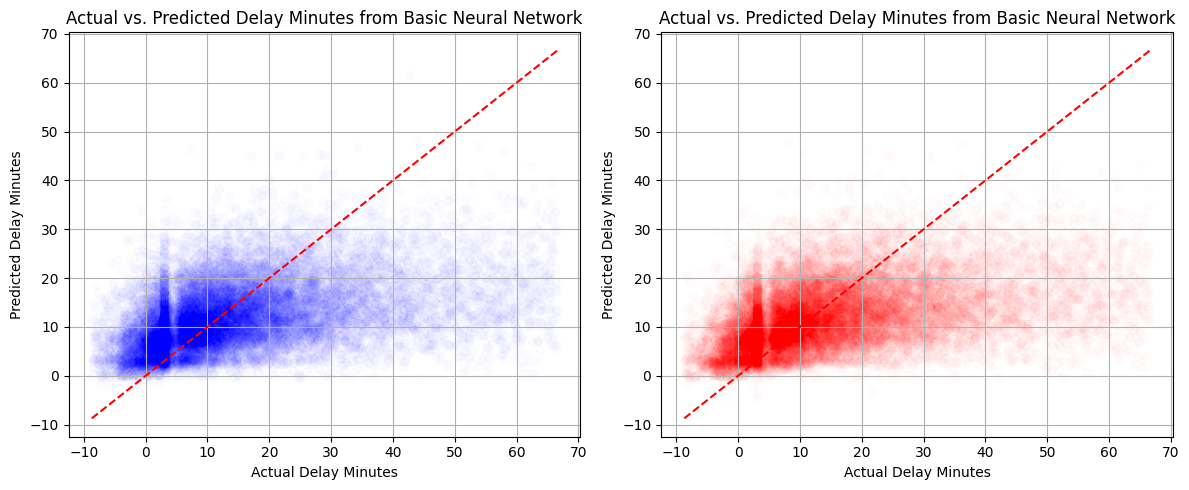

In [24]:
# Generate predictions on the test set
y_pred_test_nnBasic = model_basic.predict(X_test)
y_pred_validation_nnBasic = model_basic.predict(X_val)

plt.figure(figsize=(12,5))
# Scatter plot of actual vs. predicted values
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_test_nnBasic, alpha=0.01, color='b')  # Plot predictions vs. actual values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line y=x for reference
plt.xlabel('Actual Delay Minutes')
plt.ylabel('Predicted Delay Minutes')
plt.title('Actual vs. Predicted Delay Minutes from Basic Neural Network')
plt.grid(True)


# Scatter plot of actual vs. predicted values
plt.subplot(1,2,2)
plt.scatter(y_val, y_pred_validation_nnBasic, alpha=0.01, color='r')  # Plot predictions vs. actual values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line y=x for reference
plt.xlabel('Actual Delay Minutes')
plt.ylabel('Predicted Delay Minutes')
plt.title('Actual vs. Predicted Delay Minutes from Basic Neural Network')
plt.grid(True)

plt.tight_layout()
plt.show()

## Neural Network 2
adjusted features

In [25]:

# Define the fully connected neural network with input layer, dropout, batch normalization, and L2 regularization
model = Sequential()

# Input layer
model.add(Input(shape=(X_train.shape[1],)))  # Specify the input shape 

# FIRST of FIVE Layers
# Hidden layers with regularization, dropout, and batch normalization
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.001)))  # layer with 100 neurons / rectified linear unit activation (non linearity and helps to learn complex patterns) / l2: penalize large weights
model.add(BatchNormalization())                                         # normalize output / mean=0 and sd=1 makes training faster and stable
model.add(Dropout(0.3))                                                 # randomly drops 30% of neurons for each training step, so model does not become too dependent on single neurons

# Additional FOUR hidden layers with same setup
for _ in range(4):
    model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

# Output layer
# linear activation because the regression problem should output the predicted value directly
model.add(Dense(1, activation='linear'))  # Output layer for regression

# Compile the model
model.compile(optimizer='adam',                 # adjust the model weights during training to minimize the error
              loss='huber',                     # huber should work well for regression problems with outliers
              metrics=['mean_absolute_error'])  # track the measure for prediciton accuracy

# Callbacks to control the training process
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)              # stops training if val loss has no improvement after 10 epochs and restores the best weights
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)                  # reduces the learning Rate by half if val loss stops improving after 5 epochs -- more smooth convergence 
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')   # save the best version of the model to file 

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                    epochs=100,                                         # runs for 100 epochs if not stoped by early stopping
                    batch_size=32,                                      # updates weights every 32 samples - standard value for training
                    callbacks=[early_stopping, reduce_lr, checkpoint])

# Evaluate the model on the test set
test_loss_nnDetail, test_mae_nnDetail = model.evaluate(X_test, y_test)
print(f"\nTest Loss (Huber): {test_loss_nnDetail:.4f}")
print(f"Test MAE: {test_mae_nnDetail:.4f}")


Epoch 1/100
1799/1799 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 12.6578 - mean_absolute_error: 12.6280 - val_loss: 10.5106 - val_mean_absolute_error: 10.4693 - learning_rate: 0.0010
Epoch 2/100
1799/1799 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 10.5282 - mean_absolute_error: 10.4899 - val_loss: 10.3796 - val_mean_absolute_error: 10.3688 - learning_rate: 0.0010
Epoch 3/100
1799/1799 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 10.3919 - mean_absolute_error: 10.3934 - val_loss: 10.2189 - val_mean_absolute_error: 10.2634 - learning_rate: 0.0010
Epoch 4/100
1799/1799 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 10.2553 - mean_absolute_error: 10.3165 - val_loss: 10.1790 - val_mean_absolute_error: 10.2902 - learning_rate: 0.0010
Epoch 5/100
1799/1799 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 10.1377 - mean_absolute_error: 10.2658 - val_loss: 10.0828 - val_mean_absolute_error: 10.2526 - learning_rate: 0.0010
Epoch 6/100
1799/1799 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 10.0190 - mean_absolute_error: 

#### Predicted against Actual from Neural Network 

600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


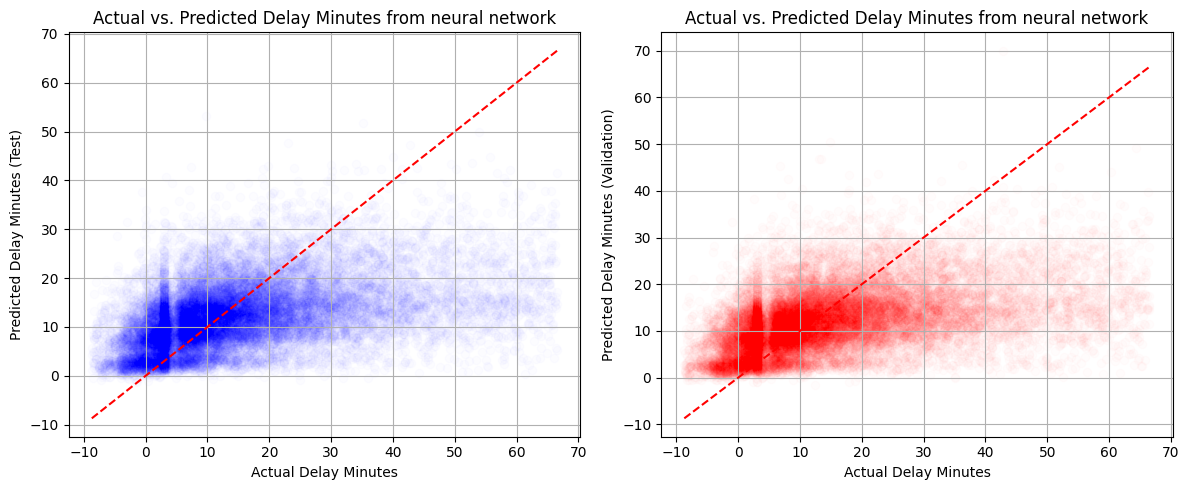

In [26]:
# Generate predictions on the test set
y_pred_test_nnDetail = model.predict(X_test)
y_pred_validation_nnDetail = model.predict(X_val)
# Scatter plot of actual vs. predicted values
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_test_nnDetail, alpha=0.01, color='b')  # Plot predictions vs. actual values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line y=x for reference
plt.xlabel('Actual Delay Minutes')
plt.ylabel('Predicted Delay Minutes (Test)')
plt.title('Actual vs. Predicted Delay Minutes from neural network')
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(y_val, y_pred_validation_nnDetail, alpha=0.01, color='r')  # Plot predictions vs. actual values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line y=x for reference
plt.xlabel('Actual Delay Minutes')
plt.ylabel('Predicted Delay Minutes (Validation)')
plt.title('Actual vs. Predicted Delay Minutes from neural network')
plt.grid(True)
plt.tight_layout()
plt.show()


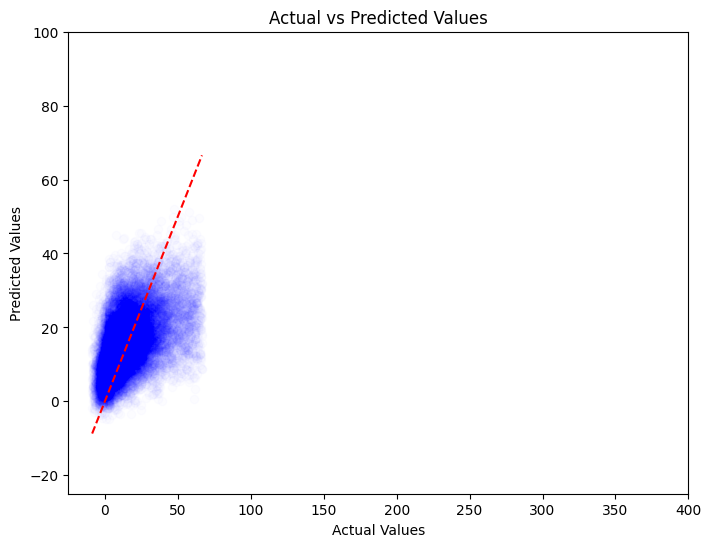

In [27]:
plt.figure(figsize=(8, 6))

# Scatter plot
plt.scatter(y_test, y_pred_test, color='blue', alpha=0.01)

# Plot a line y = x for reference (ideal predictions)
min_val = min(np.min(y_test), np.min(y_pred_test))
max_val = max(np.max(y_test), np.max(y_pred_test))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

# Labels and title
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.xlim(-25,400)
plt.ylim(-25,100)
plt.ylabel('Predicted Values')

# Show the plot
plt.show()
